# GNN

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## Read Socioeconomic Data

In [11]:
se = pd.read_csv('../Data Compilation/socioeconomic/socioeconomic_data.csv')
se

,GEO_ID,NAME,pct_no_hs,med_inc,gini,med_home_val,med_rent,med_mortgage,pct_owner_occ,pct_no_vehicle,...,pct_rent_gt35,pct_unemployed,pct_poverty,pct_single_parent,pct_nonwhite,pct_public_assist,pct_uninsured,county_fips,state,county
0,0500000US01001,"Autauga County, Alabama",90.3,69841.0,0.4515,197900.0,1200.0,1416.0,74.9,3.8,...,27.8,2.5,8.1,5.8,26.4,0.670426,7.4,1001,Alabama,Autauga County
1,0500000US01003,"Baldwin County, Alabama",91.7,75019.0,0.4589,287000.0,1211.0,1563.0,77.5,2.2,...,37.9,3.2,7.3,4.1,17.2,0.890725,8.2,1003,Alabama,Baldwin County
2,0500000US01005,"Barbour County, Alabama",77.8,44290.0,0.5061,109900.0,644.0,1185.0,67.5,11.1,...,30.7,5.7,17.7,11.1,56.0,1.850220,10.8,1005,Alabama,Barbour County
3,0500000US01007,"Bibb County, Alabama",80.3,51215.0,0.4526,132600.0,802.0,1195.0,77.2,6.5,...,46.9,10.0,16.0,7.5,24.9,5.058777,8.3,1007,Alabama,Bibb County
4,0500000US01009,"Blount County, Alabama",82.7,61096.0,0.4461,169700.0,743.0,1315.0,79.5,4.3,...,44.3,5.8,10.3,5.3,10.5,2.033945,10.2,1009,Alabama,Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,0500000US72145,"Vega Baja Municipio, Puerto Rico",77.5,23877.0,0.5365,117700.0,599.0,880.0,75.3,11.8,...,43.1,13.4,38.1,NaN,74.7,2.358168,10.0,72145,Puerto Rico,Vega Baja Municipio
3218,0500000US72147,"Vieques Municipio, Puerto Rico",69.9,17531.0,0.3972,113100.0,424.0,646.0,68.9,16.0,...,31.3,8.6,51.2,NaN,87.4,2.215546,11.4,72147,Puerto Rico,Vieques Municipio
3219,0500000US72149,"Villalba Municipio, Puerto Rico",78.9,24882.0,0.5035,103300.0,519.0,767.0,78.6,12.2,...,42.2,13.5,38.1,NaN,65.3,1.963886,2.1,72149,Puerto Rico,Villalba Municipio
3220,0500000US72151,"Yabucoa Municipio, Puerto Rico",74.5,21279.0,0.4565,95600.0,500.0,735.0,70.8,14.3,...,51.6,9.7,45.5,NaN,93.3,4.557823,4.9,72151,Puerto Rico,Yabucoa Municipio


## Read COVID-19 Data

In [12]:
# there is commmas in the case and other float columns

# Read COVID data and handle commas in numeric columns
covid = pd.read_csv('../Data Compilation/covid/United_States_COVID-19_Community_Levels_by_County_20251102.csv', 
                    dtype={'county_fips': str,
                           'county': str,
                           'state': str,
                           'date_updated': str,
                           'covid-19_community_level': str},
                    thousands=',')

# Ensure numeric columns are properly converted
numeric_cols = ['county_population', 'health_service_area_population', 
                'covid_inpatient_bed_utilization', 'covid_hospital_admissions_per_100k', 
                'covid_cases_per_100k']

for col in numeric_cols:
    if col in covid.columns:
        # Remove commas and convert to numeric
        if covid[col].dtype == 'object':
            covid[col] = covid[col].str.replace(',', '').astype(float)


covid.dtypes

county                                 object
county_fips                            object
state                                  object
county_population                     float64
health_service_area_number              int64
health_service_area                    object
health_service_area_population        float64
covid_inpatient_bed_utilization       float64
covid_hospital_admissions_per_100k    float64
covid_cases_per_100k                  float64
covid-19_community_level               object
date_updated                           object
dtype: object

## Read County Adjacency Data and Build Network

In [13]:
# Read county adjacency txt file and create edge list
edge_list = []
with open('../Data Compilation/county_adjacency2024.txt', 'r') as f:
    next(f)  # Skip header line
    for line in f:
        parts = line.strip().split('|')
        county_geoid = parts[1]
        neighbor_geoid = parts[3]
        # Skip self-loops (county adjacent to itself)
        if county_geoid != neighbor_geoid:
            edge_list.append((county_geoid, neighbor_geoid))

edge_list

G = nx.Graph()
G.add_edges_from(edge_list)

## Read Mobility Data

In [14]:
# Read mobility data for 2020, 2021, and 2022 and make sure that the census_fips_code read in as Character type
mobility2020 = pd.read_csv('../Data Compilation/mobility/2020_US_Region_Mobility_Report.csv', dtype={'census_fips_code': str})
mobility2021 = pd.read_csv('../Data Compilation/mobility/2021_US_Region_Mobility_Report.csv', dtype={'census_fips_code': str})
mobility2022 = pd.read_csv('../Data Compilation/mobility/2022_US_Region_Mobility_Report.csv', dtype={'census_fips_code': str})

mobility = pd.concat([mobility2020, mobility2021, mobility2022], ignore_index=True)

# Filter only those census_fips_code are not NaN
mobility = mobility[mobility['census_fips_code'].notna()]

## Data Preprocessing and Feature Engineering

In [15]:
# Prepare socioeconomic data - ensure FIPS is string and padded to 5 digits
se['county_fips'] = se['county_fips'].astype(str).str.zfill(5)

# Prepare COVID data - ensure FIPS is string and padded to 5 digits
covid['county_fips'] = covid['county_fips'].astype(str).str.zfill(5)

# Prepare mobility data - ensure FIPS is string and padded to 5 digits
mobility['census_fips_code'] = mobility['census_fips_code'].astype(str).str.zfill(5)

# Aggregate mobility data by county (average over time periods)
mobility_agg = mobility.groupby('census_fips_code').agg({
    'retail_and_recreation_percent_change_from_baseline': 'mean',
    'grocery_and_pharmacy_percent_change_from_baseline': 'mean',
    'parks_percent_change_from_baseline': 'mean',
    'transit_stations_percent_change_from_baseline': 'mean',
    'workplaces_percent_change_from_baseline': 'mean',
    'residential_percent_change_from_baseline': 'mean'
}).reset_index()

print(f"Socioeconomic data shape: {se.shape}")
print(f"COVID data shape: {covid.shape}")
print(f"Mobility aggregated shape: {mobility_agg.shape}")
print(f"Number of edges: {len(edge_list)}")


Socioeconomic data shape: (3222, 22)
COVID data shape: (206332, 12)
Mobility aggregated shape: (2837, 7)
Number of edges: 18960


In [16]:
# Merge all data sources on FIPS code
# Start with socioeconomic data as base
data_merged = se.copy()
data_merged = data_merged.rename(columns={'county_fips': 'fips'})

# Merge mobility data
data_merged = data_merged.merge(
    mobility_agg, 
    left_on='fips', 
    right_on='census_fips_code', 
    how='left'
)

# Merge COVID data (aggregate by county if multiple weeks)
covid_agg = covid.groupby('county_fips').agg({
    'covid-19_community_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'covid_cases_per_100k': 'mean'
}).reset_index()

data_merged = data_merged.merge(
    covid_agg,
    left_on='fips',
    right_on='county_fips',
    how='left'
)

# Drop duplicate FIPS columns
data_merged = data_merged.drop(columns=['census_fips_code', 'county_fips'], errors='ignore')

print(f"Merged data shape: {data_merged.shape}")
print(f"Columns: {list(data_merged.columns)}")
data_merged.head()


Merged data shape: (3222, 30)
Columns: ['GEO_ID', 'NAME', 'pct_no_hs', 'med_inc', 'gini', 'med_home_val', 'med_rent', 'med_mortgage', 'pct_owner_occ', 'pct_no_vehicle', 'pct_overcrowded', 'pct_vacant', 'pct_rent_gt35', 'pct_unemployed', 'pct_poverty', 'pct_single_parent', 'pct_nonwhite', 'pct_public_assist', 'pct_uninsured', 'fips', 'state', 'county', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'covid-19_community_level', 'covid_cases_per_100k']


,GEO_ID,NAME,pct_no_hs,med_inc,gini,med_home_val,med_rent,med_mortgage,pct_owner_occ,pct_no_vehicle,...,state,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,covid-19_community_level,covid_cases_per_100k
0,0500000US01001,"Autauga County, Alabama",90.3,69841.0,0.4515,197900.0,1200.0,1416.0,74.9,3.8,...,Alabama,Autauga County,-3.696523,7.792413,-19.125000,NaN,-15.859504,5.340308,Low,127.559062
1,0500000US01003,"Baldwin County, Alabama",91.7,75019.0,0.4589,287000.0,1211.0,1563.0,77.5,2.2,...,Alabama,Baldwin County,5.198152,19.670431,41.118019,7.373024,-13.016427,2.971253,Low,111.395156
2,0500000US01005,"Barbour County, Alabama",77.8,44290.0,0.5061,109900.0,644.0,1185.0,67.5,11.1,...,Alabama,Barbour County,5.403248,-2.753012,NaN,NaN,-11.661749,3.347059,Low,137.286719
3,0500000US01007,"Bibb County, Alabama",80.3,51215.0,0.4526,132600.0,802.0,1195.0,77.2,6.5,...,Alabama,Bibb County,0.823529,11.243243,NaN,NaN,-13.161222,1.989362,Low,126.568750
4,0500000US01009,"Blount County, Alabama",82.7,61096.0,0.4461,169700.0,743.0,1315.0,79.5,4.3,...,Alabama,Blount County,7.165049,7.754854,NaN,NaN,-20.513430,5.463656,Low,115.594531


In [17]:
# Create node mapping: FIPS -> node index
fips_to_idx = {fips: idx for idx, fips in enumerate(data_merged['fips'].values)}
idx_to_fips = {idx: fips for fips, idx in fips_to_idx.items()}

print(f"Number of nodes: {len(fips_to_idx)}")

# Filter edge list to only include counties in our dataset
filtered_edges = []
for source, target in edge_list:
    if source in fips_to_idx and target in fips_to_idx:
        filtered_edges.append((fips_to_idx[source], fips_to_idx[target]))

print(f"Number of valid edges: {len(filtered_edges)}")

# Convert to edge index format for PyTorch Geometric
edge_index = torch.tensor(filtered_edges, dtype=torch.long).t().contiguous()
print(f"Edge index shape: {edge_index.shape}")


Number of nodes: 3222
Number of valid edges: 18954
Edge index shape: torch.Size([2, 18954])


In [18]:
# Prepare node features
# Select numerical features (excluding FIPS, target variable, and categorical variables)
feature_cols = [col for col in data_merged.columns 
                if col not in ['fips', 'covid-19_community_level', 'covid_cases_per_100k', 'county_name', 'state_name'] 
                and data_merged[col].dtype in ['float64', 'int64']]

print(f"Selected {len(feature_cols)} features: {feature_cols}")

# Extract features and handle missing values
X = data_merged[feature_cols].fillna(0).values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensor
x = torch.tensor(X_scaled, dtype=torch.float)

print(f"Node feature matrix shape: {x.shape}")


Selected 23 features: ['pct_no_hs', 'med_inc', 'gini', 'med_home_val', 'med_rent', 'med_mortgage', 'pct_owner_occ', 'pct_no_vehicle', 'pct_overcrowded', 'pct_vacant', 'pct_rent_gt35', 'pct_unemployed', 'pct_poverty', 'pct_single_parent', 'pct_nonwhite', 'pct_public_assist', 'pct_uninsured', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
Node feature matrix shape: torch.Size([3222, 23])


In [19]:
# Prepare target variable (COVID cases per 100k)
y = torch.tensor(data_merged['covid_cases_per_100k'].fillna(0).values, dtype=torch.float)

print(f"Target shape: {y.shape}")
print(f"Target statistics - Mean: {y.mean():.2f}, Std: {y.std():.2f}, Min: {y.min():.2f}, Max: {y.max():.2f}")

# Create train/val/test masks
num_nodes = len(data_merged)
indices = np.arange(num_nodes)
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

print(f"Train: {train_mask.sum()}, Val: {val_mask.sum()}, Test: {test_mask.sum()}")


Target shape: torch.Size([3222])
Target statistics - Mean: 113.07, Std: 63.77, Min: 0.00, Max: 2302.15
Train: 2255, Val: 483, Test: 484


In [20]:
# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(data)
print(f"\nGraph statistics:")
print(f"- Number of nodes: {data.num_nodes}")
print(f"- Number of edges: {data.num_edges}")
print(f"- Number of features: {data.num_node_features}")
print(f"- Has isolated nodes: {data.has_isolated_nodes()}")
print(f"- Has self-loops: {data.has_self_loops()}")
print(f"- Is undirected: {data.is_undirected()}")


Data(x=[3222, 23], edge_index=[2, 18954], y=[3222], train_mask=[3222], val_mask=[3222], test_mask=[3222])

Graph statistics:
- Number of nodes: 3222
- Number of edges: 18954
- Number of features: 23
- Has isolated nodes: True
- Has self-loops: False
- Is undirected: True
- Has isolated nodes: True
- Has self-loops: False
- Is undirected: True


## GNN Model Definition

In [21]:
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, dropout=0.5):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels // 2)
        self.fc = torch.nn.Linear(hidden_channels // 2, 1)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Output layer
        x = self.fc(x)
        
        return x.squeeze()

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_features=data.num_node_features, hidden_channels=64, dropout=0.2).to(device)
data = data.to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cpu

Model architecture:
GNN(
  (conv1): GCNConv(23, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 7,809


## Model Training

In [22]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask]
        target = data.y[mask]
        loss = criterion(pred, target)
        mse = F.mse_loss(pred, target)
        mae = F.l1_loss(pred, target)
    return loss.item(), mse.item(), mae.item()

# Setup training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

# Training loop
epochs = 200
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")
for epoch in range(1, epochs + 1):
    train_loss = train()
    train_losses.append(train_loss)
    
    val_loss, val_mse, val_mae = evaluate(data.val_mask)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")


Starting training...
Epoch 020, Train Loss: 5044.1631, Val Loss: 1956.9977, Val MAE: 34.3138
Epoch 020, Train Loss: 5044.1631, Val Loss: 1956.9977, Val MAE: 34.3138
Epoch 040, Train Loss: 3833.4963, Val Loss: 1350.2697, Val MAE: 28.2633
Epoch 040, Train Loss: 3833.4963, Val Loss: 1350.2697, Val MAE: 28.2633
Epoch 060, Train Loss: 3664.8386, Val Loss: 1182.4598, Val MAE: 26.5868
Epoch 060, Train Loss: 3664.8386, Val Loss: 1182.4598, Val MAE: 26.5868
Epoch 080, Train Loss: 3394.6570, Val Loss: 1085.0094, Val MAE: 25.4475
Epoch 080, Train Loss: 3394.6570, Val Loss: 1085.0094, Val MAE: 25.4475
Epoch 100, Train Loss: 3294.2434, Val Loss: 1054.2179, Val MAE: 25.0783
Epoch 100, Train Loss: 3294.2434, Val Loss: 1054.2179, Val MAE: 25.0783
Epoch 120, Train Loss: 3298.1204, Val Loss: 1039.9670, Val MAE: 24.9947
Epoch 120, Train Loss: 3298.1204, Val Loss: 1039.9670, Val MAE: 24.9947
Epoch 140, Train Loss: 3265.2866, Val Loss: 1051.7471, Val MAE: 25.2139
Epoch 140, Train Loss: 3265.2866, Val Loss:

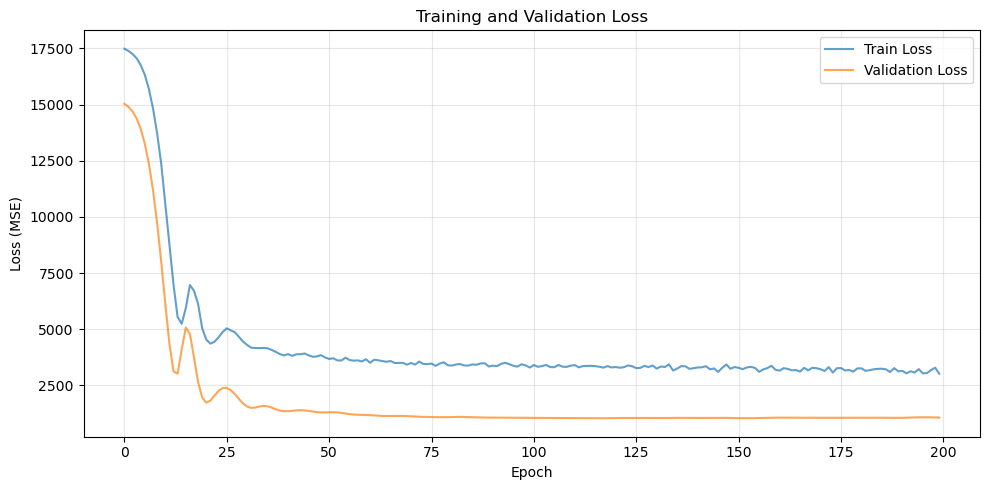

In [23]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Model Evaluation

In [24]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_mse, test_mae = evaluate(data.test_mask)

print("Test Set Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {np.sqrt(test_mse):.4f}")

# Get predictions
model.eval()
with torch.no_grad():
    predictions = model(data.x, data.edge_index).cpu().numpy()
    actual = data.y.cpu().numpy()

# Calculate R² score
from sklearn.metrics import r2_score
test_r2 = r2_score(actual[data.test_mask.cpu()], predictions[data.test_mask.cpu()])
print(f"  R² Score: {test_r2:.4f}")


Test Set Performance:
  MSE: 1574.8737
  MAE: 27.9195
  RMSE: 39.6847
  R² Score: 0.4384


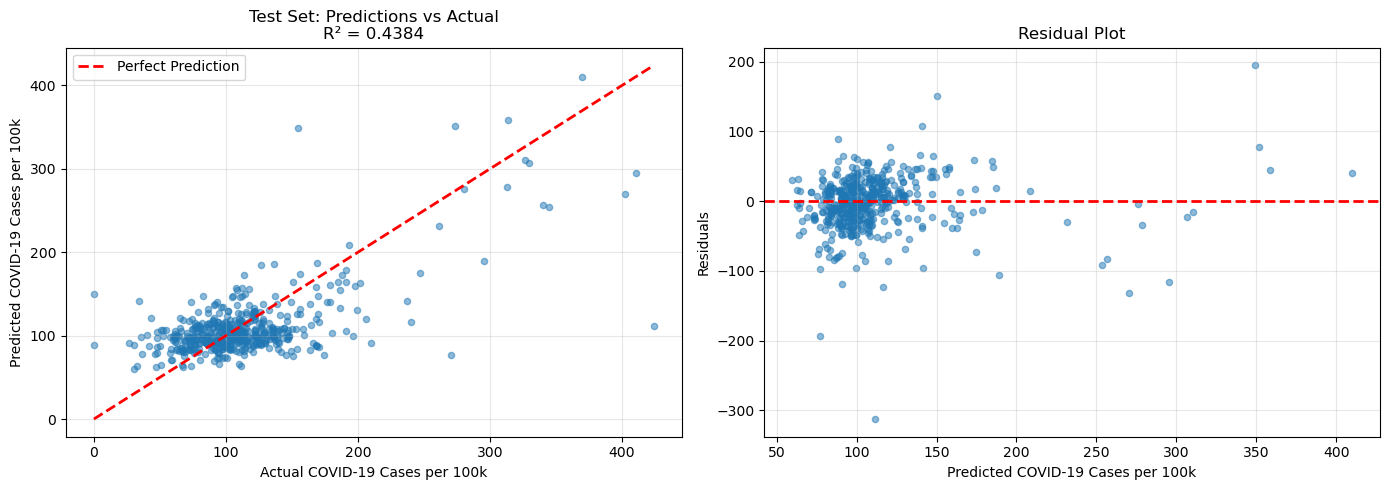

In [25]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test set scatter plot
test_pred = predictions[data.test_mask.cpu()]
test_actual = actual[data.test_mask.cpu()]

axes[0].scatter(test_actual, test_pred, alpha=0.5, s=20)
axes[0].plot([test_actual.min(), test_actual.max()], 
             [test_actual.min(), test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual COVID-19 Cases per 100k')
axes[0].set_ylabel('Predicted COVID-19 Cases per 100k')
axes[0].set_title(f'Test Set: Predictions vs Actual\nR² = {test_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = test_pred - test_actual
axes[1].scatter(test_pred, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted COVID-19 Cases per 100k')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Feature Importance Analysis

In [26]:
def compute_feature_importance(model, data, feature_names, num_permutations=10):
    """
    Compute feature importance using permutation importance method.
    For each feature, we permute its values and measure the increase in prediction error.
    """
    model.eval()
    
    # Get baseline predictions and error
    with torch.no_grad():
        baseline_pred = model(data.x, data.edge_index).cpu().numpy()
        baseline_mse = F.mse_loss(
            torch.tensor(baseline_pred[data.test_mask.cpu()]),
            torch.tensor(actual[data.test_mask.cpu()])
        ).item()
    
    importance_scores = []
    
    print("Computing feature importance...")
    for feature_idx in range(data.num_node_features):
        feature_mse_increases = []
        
        for _ in range(num_permutations):
            # Create a copy of the data
            x_permuted = data.x.clone()
            
            # Permute the feature values
            perm_indices = torch.randperm(x_permuted.shape[0])
            x_permuted[:, feature_idx] = x_permuted[perm_indices, feature_idx]
            
            # Get predictions with permuted feature
            with torch.no_grad():
                permuted_pred = model(x_permuted, data.edge_index).cpu().numpy()
                permuted_mse = F.mse_loss(
                    torch.tensor(permuted_pred[data.test_mask.cpu()]),
                    torch.tensor(actual[data.test_mask.cpu()])
                ).item()
            
            # Calculate increase in MSE
            mse_increase = permuted_mse - baseline_mse
            feature_mse_increases.append(mse_increase)
        
        # Average over permutations
        avg_importance = np.mean(feature_mse_increases)
        importance_scores.append(avg_importance)
        
        if (feature_idx + 1) % 5 == 0:
            print(f"  Processed {feature_idx + 1}/{data.num_node_features} features")
    
    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=False)
    
    return importance_df

# Compute feature importance
feature_importance = compute_feature_importance(model, data, feature_cols, num_permutations=10)
print("\nFeature Importance (Top 20):")
print(feature_importance.head(20))

Computing feature importance...
  Processed 5/23 features
  Processed 5/23 features
  Processed 10/23 features
  Processed 10/23 features
  Processed 15/23 features
  Processed 15/23 features
  Processed 20/23 features

Feature Importance (Top 20):
                                              Feature  Importance
1                                             med_inc  277.803381
22           residential_percent_change_from_baseline  170.268799
13                                  pct_single_parent  137.774365
12                                        pct_poverty  112.657239
5                                        med_mortgage  106.784851
8                                     pct_overcrowded  105.927307
20      transit_stations_percent_change_from_baseline  104.690283
21            workplaces_percent_change_from_baseline   82.979309
0                                           pct_no_hs   74.259277
2                                                gini   57.145654
4                        

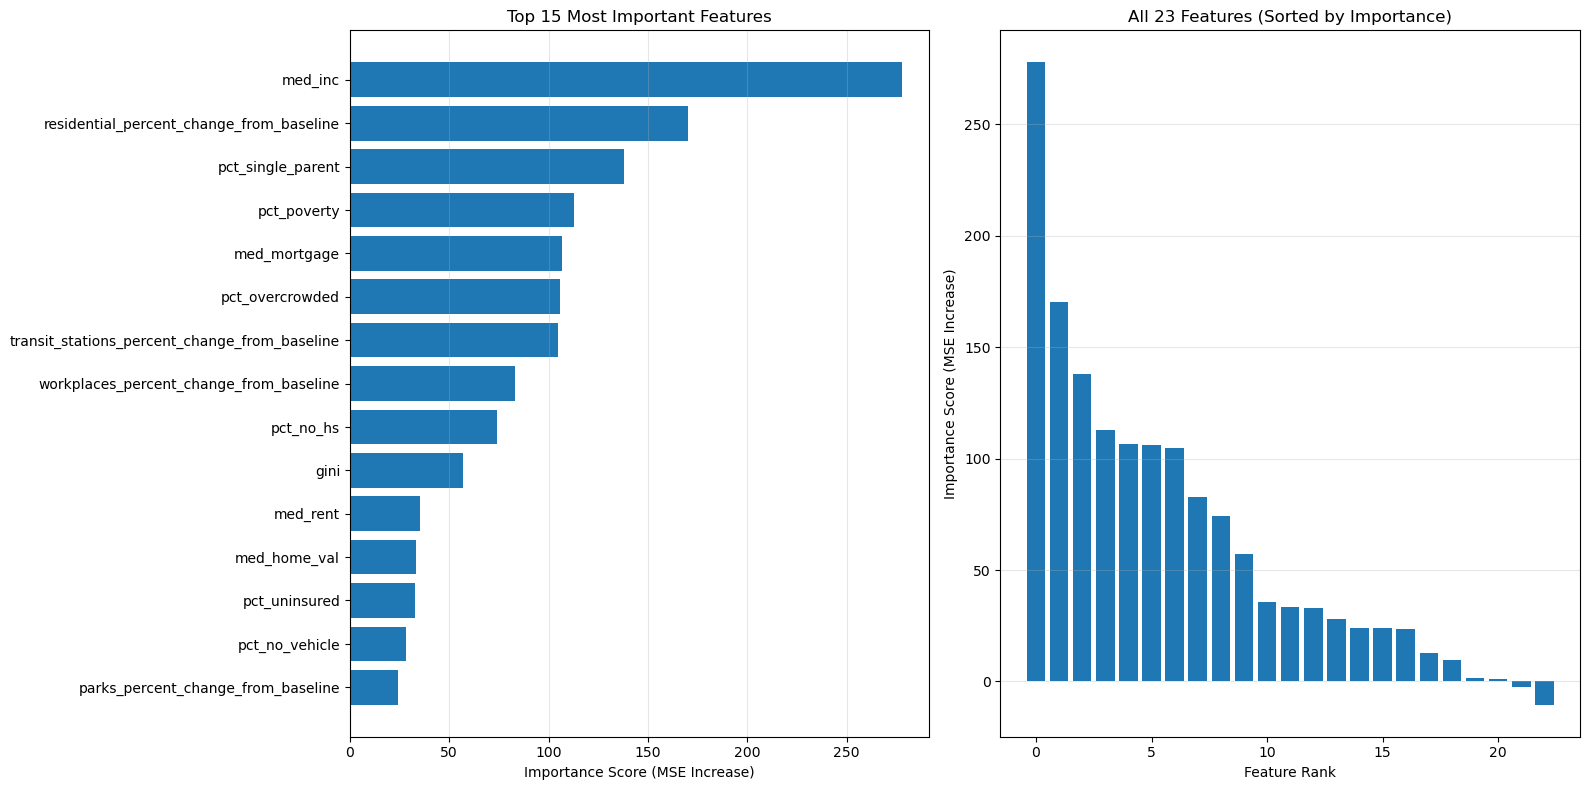


Feature Importance Statistics:
  Mean: 62.8026
  Median: 33.4336
  Std: 68.3291
  Min: -10.3915
  Max: 277.8034


In [27]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features bar plot
top_features = feature_importance.head(15)
axes[0].barh(range(len(top_features)), top_features['Importance'].values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].set_xlabel('Importance Score (MSE Increase)')
axes[0].set_title('Top 15 Most Important Features')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# All features sorted
axes[1].bar(range(len(feature_importance)), feature_importance['Importance'].values)
axes[1].set_xlabel('Feature Rank')
axes[1].set_ylabel('Importance Score (MSE Increase)')
axes[1].set_title(f'All {len(feature_importance)} Features (Sorted by Importance)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nFeature Importance Statistics:")
print(f"  Mean: {feature_importance['Importance'].mean():.4f}")
print(f"  Median: {feature_importance['Importance'].median():.4f}")
print(f"  Std: {feature_importance['Importance'].std():.4f}")
print(f"  Min: {feature_importance['Importance'].min():.4f}")
print(f"  Max: {feature_importance['Importance'].max():.4f}")

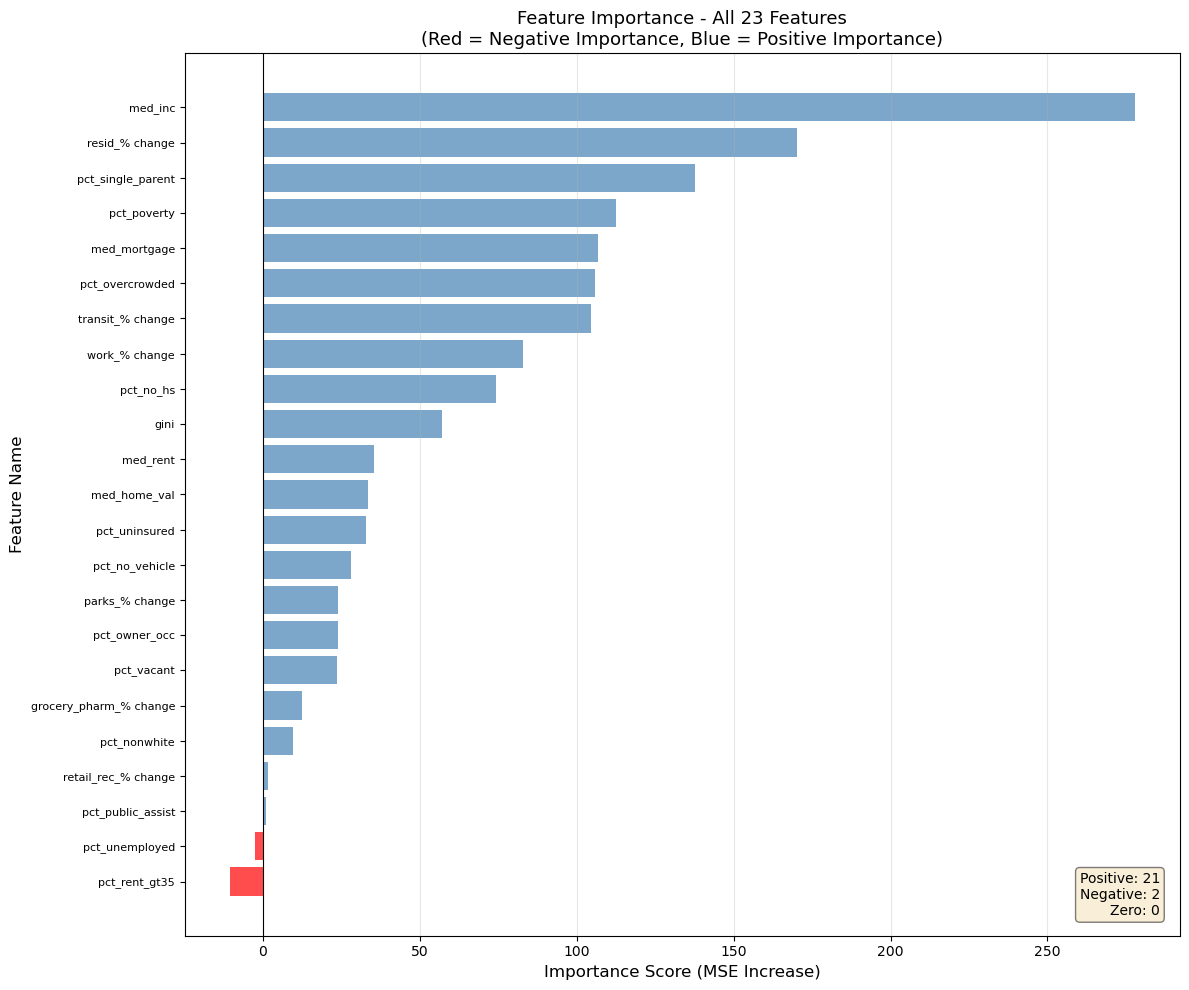


Top 10 Most Important Features (Positive Impact):
  med_inc                                 : 277.8034
  resid_% change                          : 170.2688
  pct_single_parent                       : 137.7744
  pct_poverty                             : 112.6572
  med_mortgage                            : 106.7849
  pct_overcrowded                         : 105.9273
  transit_% change                        : 104.6903
  work_% change                           :  82.9793
  pct_no_hs                               :  74.2593
  gini                                    :  57.1457

Top 10 Least Important Features (Negative Impact):
  pct_unemployed                          :  -2.2970
  pct_rent_gt35                           : -10.3915


In [28]:
# Create shortened feature names for better readability
def shorten_feature_name(name, max_length=30):
    """Shorten long feature names while keeping them readable"""
    replacements = {
        'percent_change_from_baseline': '% change',
        'retail_and_recreation': 'retail_rec',
        'grocery_and_pharmacy': 'grocery_pharm',
        'transit_stations': 'transit',
        'workplaces': 'work',
        'residential': 'resid',
        'Estimate': 'Est',
        'Percent': 'Pct',
        'Total population': 'Total pop',
        'population': 'pop',
        'households': 'HH',
        'Median': 'Med',
        'household': 'HH',
        'income': 'inc',
        'unemployment': 'unemp',
        'health insurance': 'health ins',
        'coverage': 'cov',
        'educational': 'educ',
        'attainment': 'attain'
    }
    
    short_name = name
    for old, new in replacements.items():
        short_name = short_name.replace(old, new)
    
    if len(short_name) > max_length:
        short_name = short_name[:max_length-3] + '...'
    
    return short_name

# Apply shortened names
feature_importance['Short_Feature'] = feature_importance['Feature'].apply(shorten_feature_name)

# Plot all features with color coding for negative importance (horizontal bar plot)
plt.figure(figsize=(12, max(10, len(feature_importance) * 0.3)))

colors = ['red' if x < 0 else 'steelblue' for x in feature_importance['Importance'].values]

# Reverse the order so most important is at the top
feature_importance_reversed = feature_importance.iloc[::-1]
colors_reversed = colors[::-1]

bars = plt.barh(range(len(feature_importance_reversed)), 
                feature_importance_reversed['Importance'].values, 
                color=colors_reversed, alpha=0.7)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Add y-axis labels with feature names
plt.yticks(range(len(feature_importance_reversed)), 
           feature_importance_reversed['Short_Feature'].values, fontsize=8)
plt.ylabel('Feature Name', fontsize=12)
plt.xlabel('Importance Score (MSE Increase)', fontsize=12)
plt.title(f'Feature Importance - All {len(feature_importance)} Features\n(Red = Negative Importance, Blue = Positive Importance)', fontsize=13)
plt.grid(True, alpha=0.3, axis='x')

# Add text box with statistics
textstr = f'Positive: {(feature_importance["Importance"] > 0).sum()}\nNegative: {(feature_importance["Importance"] < 0).sum()}\nZero: {(feature_importance["Importance"] == 0).sum()}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.98, 0.02, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print top positive and negative features
print("\nTop 10 Most Important Features (Positive Impact):")
top_positive = feature_importance[feature_importance['Importance'] > 0].head(10)
for idx, row in top_positive.iterrows():
    print(f"  {row['Short_Feature']:40s}: {row['Importance']:8.4f}")

print("\nTop 10 Least Important Features (Negative Impact):")
bottom_negative = feature_importance[feature_importance['Importance'] < 0].tail(10)
for idx, row in bottom_negative.iterrows():
    print(f"  {row['Short_Feature']:40s}: {row['Importance']:8.4f}")

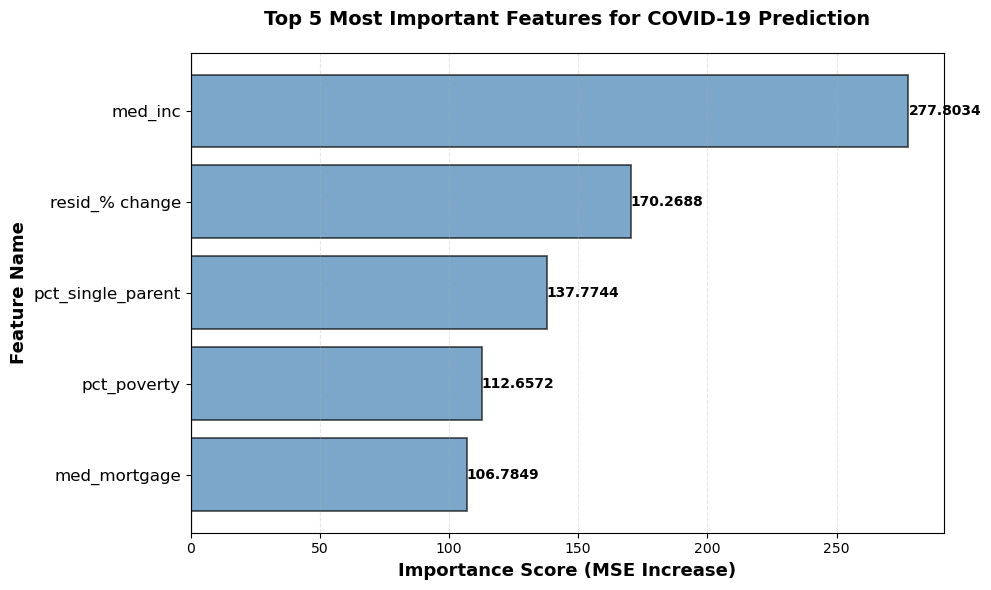


TOP 5 MOST IMPORTANT FEATURES

Rank 1:
  Feature (Short): med_inc
  Feature (Full):  med_inc
  Importance:      277.803381
  Impact:          Positive

Rank 2:
  Feature (Short): resid_% change
  Feature (Full):  residential_percent_change_from_baseline
  Importance:      170.268799
  Impact:          Positive

Rank 3:
  Feature (Short): pct_single_parent
  Feature (Full):  pct_single_parent
  Importance:      137.774365
  Impact:          Positive

Rank 4:
  Feature (Short): pct_poverty
  Feature (Full):  pct_poverty
  Importance:      112.657239
  Impact:          Positive

Rank 5:
  Feature (Short): med_mortgage
  Feature (Full):  med_mortgage
  Importance:      106.784851
  Impact:          Positive


In [30]:
# Visualize top 5 most important features
plt.figure(figsize=(10, 6))

# Get top 5 features
top_5_features = feature_importance.head(5)

# Create color list
colors_top5 = ['steelblue' if x > 0 else 'red' for x in top_5_features['Importance'].values]

# Reverse order for better visualization (most important at top)
top_5_reversed = top_5_features.iloc[::-1]
colors_top5_reversed = colors_top5[::-1]

# Create horizontal bar plot
bars = plt.barh(range(len(top_5_reversed)), 
                top_5_reversed['Importance'].values, 
                color=colors_top5_reversed, alpha=0.7, edgecolor='black', linewidth=1.2)

# Add vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Set y-axis labels with shortened feature names
plt.yticks(range(len(top_5_reversed)), 
           top_5_reversed['Short_Feature'].values, fontsize=12)

# Labels and title
plt.ylabel('Feature Name', fontsize=13, fontweight='bold')
plt.xlabel('Importance Score (MSE Increase)', fontsize=13, fontweight='bold')
plt.title('Top 5 Most Important Features for COVID-19 Prediction', 
          fontsize=14, fontweight='bold', pad=20)

# Add grid
plt.grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(top_5_reversed.iterrows()):
    value = row['Importance']
    x_pos = value + (0.02 if value > 0 else -0.02)
    ha = 'left' if value > 0 else 'right'
    plt.text(x_pos, i, f'{value:.4f}', va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed information
print("\n" + "="*80)
print("TOP 5 MOST IMPORTANT FEATURES")
print("="*80)
for rank, (idx, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"\nRank {rank}:")
    print(f"  Feature (Short): {row['Short_Feature']}")
    print(f"  Feature (Full):  {row['Feature']}")
    print(f"  Importance:      {row['Importance']:.6f}")
    print(f"  Impact:          {'Positive' if row['Importance'] > 0 else 'Negative'}")
print("="*80)

## Model Improvement Strategies

In [57]:
# Improved GNN Model with GAT and residual connections
class ImprovedGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, dropout=0.3):
        super(ImprovedGNN, self).__init__()
        
        # Use Graph Attention Network (GAT) for better feature learning
        self.conv1 = GATConv(num_features, hidden_channels, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=2, dropout=dropout)
        
        # Batch normalization for training stability
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * 4)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels * 4)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels * 2)
        
        # Multi-layer prediction head
        self.fc1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc3 = torch.nn.Linear(hidden_channels // 2, 1)
        
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GAT layer with batch norm
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GAT layer with batch norm
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Third GAT layer with batch norm
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Multi-layer prediction head
        x = self.fc1(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc2(x)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.fc3(x)
        
        return x.squeeze()

# Initialize improved model
improved_model = ImprovedGNN(num_features=data.num_node_features, hidden_channels=64, dropout=0.3).to(device)

print(f"Improved Model architecture:")
print(improved_model)
print(f"\nTotal parameters: {sum(p.numel() for p in improved_model.parameters()):,}")

Improved Model architecture:
ImprovedGNN(
  (conv1): GATConv(23, 64, heads=4)
  (conv2): GATConv(256, 64, heads=4)
  (conv3): GATConv(256, 64, heads=2)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 117,761


In [59]:
# Training with learning rate scheduling and early stopping
def train_improved():
    improved_model.train()
    optimizer.zero_grad()
    out = improved_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(improved_model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    return loss.item()

def evaluate_improved(mask):
    improved_model.eval()
    with torch.no_grad():
        out = improved_model(data.x, data.edge_index)
        pred = out[mask]
        target = data.y[mask]
        loss = criterion(pred, target)
        mse = F.mse_loss(pred, target)
        mae = F.l1_loss(pred, target)
    return loss.item(), mse.item(), mae.item()

# Setup training with Adam + learning rate scheduler
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                        patience=20)
criterion = torch.nn.MSELoss()

# Training loop with early stopping
epochs = 500
train_losses_improved = []
val_losses_improved = []
best_val_loss = float('inf')
patience = 50
patience_counter = 0

print("Training improved model...")
for epoch in range(1, epochs + 1):
    train_loss = train_improved()
    train_losses_improved.append(train_loss)
    
    val_loss, val_mse, val_mae = evaluate_improved(data.val_mask)
    val_losses_improved.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(improved_model.state_dict(), 'best_improved_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 25 == 0:
        print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

Training improved model...
Epoch 025, Train Loss: 16827.8672, Val Loss: 14489.4385, Val MAE: 109.7646
Epoch 025, Train Loss: 16827.8672, Val Loss: 14489.4385, Val MAE: 109.7646
Epoch 050, Train Loss: 14726.6416, Val Loss: 12401.0957, Val MAE: 102.8424
Epoch 050, Train Loss: 14726.6416, Val Loss: 12401.0957, Val MAE: 102.8424
Epoch 075, Train Loss: 11060.8330, Val Loss: 8819.2627, Val MAE: 84.5966
Epoch 075, Train Loss: 11060.8330, Val Loss: 8819.2627, Val MAE: 84.5966
Epoch 100, Train Loss: 7883.2798, Val Loss: 5653.9302, Val MAE: 60.5066
Epoch 100, Train Loss: 7883.2798, Val Loss: 5653.9302, Val MAE: 60.5066
Epoch 125, Train Loss: 4948.4106, Val Loss: 4035.6455, Val MAE: 44.9539
Epoch 125, Train Loss: 4948.4106, Val Loss: 4035.6455, Val MAE: 44.9539
Epoch 150, Train Loss: 5054.5913, Val Loss: 2913.7043, Val MAE: 38.0618
Epoch 150, Train Loss: 5054.5913, Val Loss: 2913.7043, Val MAE: 38.0618
Epoch 175, Train Loss: 4043.0066, Val Loss: 2309.4172, Val MAE: 32.6628
Epoch 175, Train Loss: 

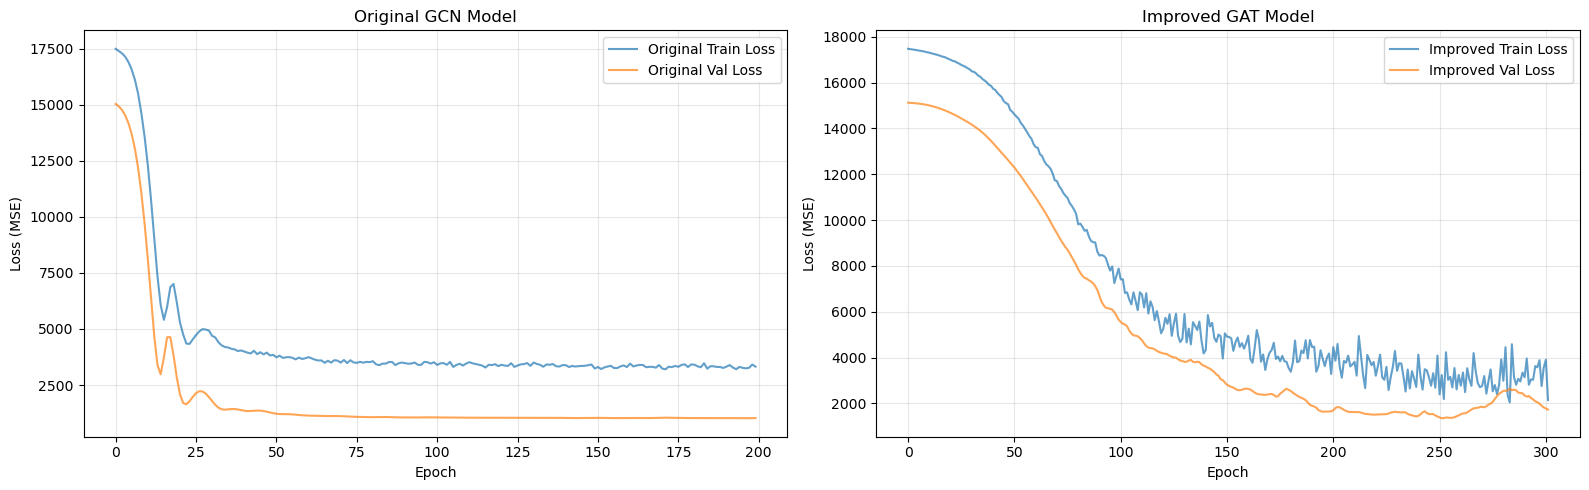

In [60]:
# Compare training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original model
axes[0].plot(train_losses, label='Original Train Loss', alpha=0.7)
axes[0].plot(val_losses, label='Original Val Loss', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Original GCN Model')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Improved model
axes[1].plot(train_losses_improved, label='Improved Train Loss', alpha=0.7)
axes[1].plot(val_losses_improved, label='Improved Val Loss', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title('Improved GAT Model')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [61]:
# Evaluate improved model
improved_model.load_state_dict(torch.load('best_improved_model.pt'))
test_loss_imp, test_mse_imp, test_mae_imp = evaluate_improved(data.test_mask)

print("=" * 60)
print("MODEL COMPARISON - Test Set Performance")
print("=" * 60)

print("\nOriginal GCN Model:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {np.sqrt(test_mse):.4f}")
print(f"  R²:   {test_r2:.4f}")

print("\nImproved GAT Model:")
print(f"  MSE:  {test_mse_imp:.4f}")
print(f"  MAE:  {test_mae_imp:.4f}")
print(f"  RMSE: {np.sqrt(test_mse_imp):.4f}")

# Get improved predictions
improved_model.eval()
with torch.no_grad():
    predictions_imp = improved_model(data.x, data.edge_index).cpu().numpy()

test_r2_imp = r2_score(actual[data.test_mask.cpu()], predictions_imp[data.test_mask.cpu()])
print(f"  R²:   {test_r2_imp:.4f}")

print("\nImprovement:")
print(f"  MAE Reduction:  {((test_mae - test_mae_imp) / test_mae * 100):.2f}%")
print(f"  RMSE Reduction: {((np.sqrt(test_mse) - np.sqrt(test_mse_imp)) / np.sqrt(test_mse) * 100):.2f}%")
print(f"  R² Increase:    {((test_r2_imp - test_r2) / abs(test_r2) * 100):.2f}%")
print("=" * 60)

MODEL COMPARISON - Test Set Performance

Original GCN Model:
  MSE:  1567.3646
  MAE:  27.4770
  RMSE: 39.5900
  R²:   0.4410

Improved GAT Model:
  MSE:  1673.0570
  MAE:  28.0547
  RMSE: 40.9030
  R²:   0.4034

Improvement:
  MAE Reduction:  -2.10%
  RMSE Reduction: -3.32%
  R² Increase:    -8.55%


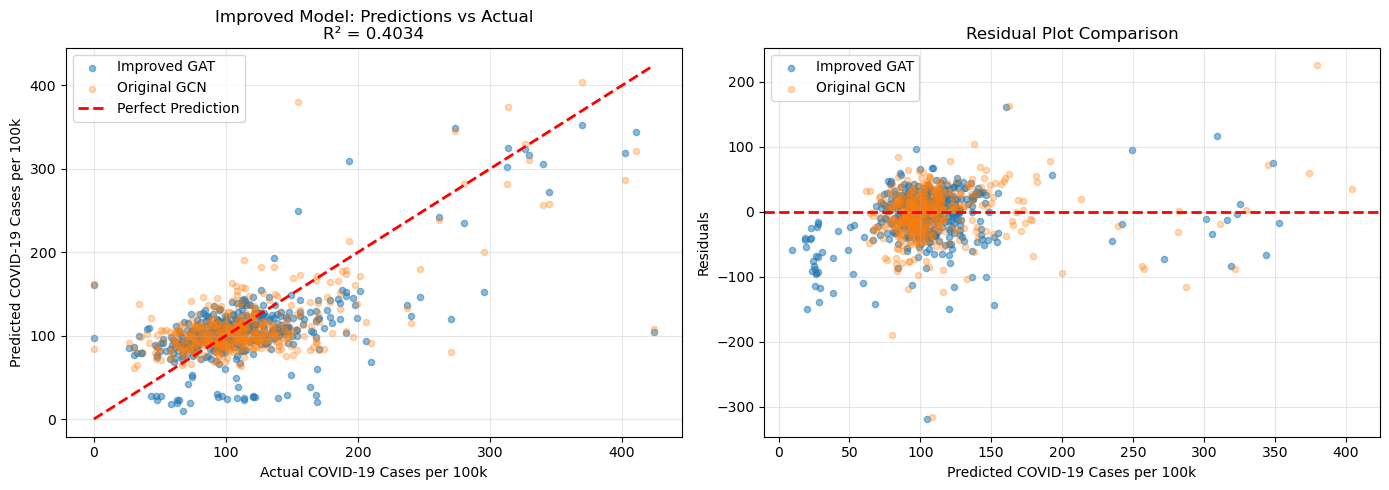

In [62]:
# Visualize improved model predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

test_pred_imp = predictions_imp[data.test_mask.cpu()]
test_actual = actual[data.test_mask.cpu()]

# Predictions vs Actual
axes[0].scatter(test_actual, test_pred_imp, alpha=0.5, s=20, label='Improved GAT')
axes[0].scatter(test_actual, test_pred, alpha=0.3, s=20, label='Original GCN')
axes[0].plot([test_actual.min(), test_actual.max()], 
             [test_actual.min(), test_actual.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual COVID-19 Cases per 100k')
axes[0].set_ylabel('Predicted COVID-19 Cases per 100k')
axes[0].set_title(f'Improved Model: Predictions vs Actual\nR² = {test_r2_imp:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual comparison
residuals_imp = test_pred_imp - test_actual
axes[1].scatter(test_pred_imp, residuals_imp, alpha=0.5, s=20, label='Improved GAT')
axes[1].scatter(test_pred, residuals, alpha=0.3, s=20, label='Original GCN')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted COVID-19 Cases per 100k')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()